In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPool2D,AveragePooling2D,Dropout,Activation,Input,Concatenate,Add,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import os
import cv2
import imageio

In [14]:

def resolution_block(input_layer,n_convs,filters,kernel_size,padding = 'same',kernel_initializer = 'glorot_uniform',
                     batch_norm = False,dropout = None,activation = 'relu',add = True,strides = 1,name = '_'):
    '''
    Create a fully convolutional block with parameters
    inputs :
        n_convs : number of convolutional layers
        
    outputs:
        convs : 
    '''
    x = input_layer
    for i in range(n_convs):
        x = Conv2D(filters= filters,
                   kernel_size = kernel_size ,
                   strides= strides,
                   padding=padding,
                   kernel_initializer=kernel_initializer,
                   #name = 'conv_'+str(i+1)+ '_' + name
                   )(x)
        if batch_norm :
            x = BatchNormalization()(x)
        x = Activation(activation)(x)  
    if dropout : 
        x = Dropout(dropout)(x)
    
    if add :
        x = Add()([input_layer,x])
        x = Activation('relu')(x)
    
    return x


def create_n_blocks(n ,*args,**kwargs):
    x = args[0]
    for i in range (n):
        x = resolution_block(x,*args[1:],**kwargs)
    return x


In [15]:
def transition_up(input_layer,filters,target_size=0,batch_norm = False,activation = 'relu'):
    
    x = input_layer
    size = input_layer.shape[1]
    ratio = target_size/size
    x = UpSampling2D(size = int(ratio))(x)
    x = Conv2D(filters=filters,kernel_size=(1,1),padding = 'same')(x)
    if batch_norm :
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    return x


    

In [16]:

input_layer = Input(shape = (256,256,3))

x = resolution_block(input_layer,1,filters=32,kernel_size=3,add=False)

high_res1 = create_n_blocks(3,x,3,32,3,name = 'res_256')
down_high_res1 = resolution_block(high_res1,1,filters=64,kernel_size=3,strides=2,name = 'down_256_128',add = False)

high_res2 = create_n_blocks(3,high_res1,3,32,3,name ='res2_256')
low1_res1 = create_n_blocks(3,down_high_res1,3,64,3,name = 'res_128',batch_norm=True)


down_low1_res1 = resolution_block(low1_res1,1,filters=128,kernel_size=3,strides=2,name = 'down_128_64',add = False)
up_low1_res1 = transition_up(low1_res1,32,256)

down_256_128 = resolution_block(high_res2,1,filters=64,kernel_size=3,strides=2,name = 'down_256_128_2',add = False)
down_256_64 = resolution_block(high_res2,1,filters=128,kernel_size=3,strides=4,name = 'down_256_64',add = False)



add1 = Add()([up_low1_res1,high_res2])
add2 = Add()([down_256_128,low1_res1])
add3 = Add()([down_256_64,down_low1_res1])


res256_3 = create_n_blocks(3,add1,2,32,3,name= 'res3_256',batch_norm=True)
res128_2 = create_n_blocks(3,add2,2,64,3,name= 'res2_128',batch_norm=True)
res64_1  = create_n_blocks(3,add3,2,128,3,name= 'res1_64',batch_norm=True)

# connections from 265 resolutional block
down_256_128_3 = resolution_block(res256_3,1,filters=64,kernel_size=3,strides=2,name = 'down_256_128_3',add = False)
down_256_64_3 = resolution_block(res256_3,1,filters=128,kernel_size=3,strides=4,name = 'down_256_64_3',add = False)
down_256_32_3 = resolution_block(res256_3,1,filters=256,kernel_size=3,strides=8,name = 'down_256_32_3',add = False)

# connections from 128 resolutional block
down_128_64_2 = resolution_block(res128_2,1,filters=128,kernel_size=3,strides=2,name='down_128_64_2',add = False)
down_128_32_2 = resolution_block(res128_2,1,filters=256,kernel_size=3,strides=4,name='down_128_32_2',add = False)
up_128_256_2 = transition_up(res128_2,32,256)

#connections from 64 resolutional block
down_64_32_1 = resolution_block(res64_1,1,filters=256,kernel_size=3,strides=2,name='down_64_32_1',add = False)
up_64_128_1 = transition_up(res64_1,64,128)
up_64_256_1 = transition_up(res64_1,32,256)

# additions of 3rd stage
add1_3 = Add()([res256_3,up_128_256_2,up_64_256_1])
add2_3 = Add()([res128_2,down_256_128_3,up_64_128_1])
add3_3 = Add()([res64_1,down_256_64_3,down_128_64_2])
add4_3 = Add()([down_256_32_3,down_128_32_2,down_64_32_1])


# 4th stage convolutions
res256_4 = create_n_blocks(3,add1_3,2,32,3,name= 'res4_256',batch_norm=True)
res128_3 = create_n_blocks(3,add2_3,2,64,3,name= 'res3_128',batch_norm=True)
res64_2  = create_n_blocks(3,add3_3,2,128,3,name= 'res2_64',batch_norm=True)
res32_1  = create_n_blocks(3,add4_3,2,256,3,name= 'res1_32',batch_norm=True)

# connections from 265 resolutional block
down_256_128_4 = resolution_block(res256_4,1,filters=64,kernel_size=3,strides=2,name = 'down_256_128_4',add = False)
down_256_64_4 = resolution_block(res256_4,1,filters=128,kernel_size=3,strides=4,name = 'down_256_64_4',add = False)
down_256_32_4 = resolution_block(res256_4,1,filters=256,kernel_size=3,strides=8,name = 'down_256_32_4',add = False)

# connections from 128 resolutional block
down_128_64_3 = resolution_block(res128_3,1,filters=128,kernel_size=3,strides=2,name='down_128_64_3',add = False)
down_128_32_3 = resolution_block(res128_3,1,filters=256,kernel_size=3,strides=4,name='down_128_32_3',add = False)
up_128_256_3 = transition_up(res128_3,32,256)

#connections from 64 resolutional block
down_64_32_2 = resolution_block(res64_2,1,filters=256,kernel_size=3,strides=2,name='down_64_32_2',add = False)
up_64_128_2 = transition_up(res64_2,64,128)
up_64_256_2 = transition_up(res64_2,32,256)

#connections from 32 resolutional block
up_32_256_1 = transition_up(res32_1,32,256)
up_32_128_1 = transition_up(res32_1,64,128)
up_32_64_1 = transition_up(res32_1,128,64)

# additions of 4rd stage
add1_4 = Add()([res256_4,up_128_256_3,up_64_256_2,up_32_256_1])
add2_4 = Add()([res128_3,down_256_128_4,up_64_128_2,up_32_128_1])
add3_4 = Add()([res64_2,down_256_64_4,down_128_64_3,up_32_64_1])
add4_4 = Add()([res32_1,down_256_32_4,down_128_32_3,down_64_32_2])


# representation layer
up_32_256_f = transition_up(add2_4,32,256)
up_64_256_f = transition_up(add3_4,32,256)
up_128_256_f = transition_up(add4_4,32,256)

concat = Concatenate()([add1_4,up_128_256_f,up_64_256_f,up_32_256_f])
#classify = transition_up(concat,32,512,activation='softmax')
classify = resolution_block(concat,1,filters=32,kernel_size=3,padding='same',activation='softmax',add=False)

#down_128_64_2 = resolution_block(res128_2,1,filters= 128,kernel_size=3,strides=2)

model = Model(inputs = input_layer,outputs= [classify])


plot_model(model,show_shapes = True)

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
activation_130 (Activation)     (None, 256, 256, 32) 0           conv2d_100[0][0]                 
__________________________________________________________________________________________________
conv2d_101 (Conv2D)             (None, 256, 256, 32) 9248        activation_130[0][0]             
____________________________________________________________________________________________

In [18]:
PATH = "D:\iti\SelfStudy\Semantic_segmentation\Semantic_Segmentation_Models"
import pandas as pd
labels = pd.read_csv(os.path.join(PATH,'labels.csv'),index_col=0)
mapping_dict = {label:list(labels.loc[label,:]) for label in labels.index}

In [19]:
# changing mask
def preprocess_mask(classes,mask_img):
    ''' 
    preprocess the mask image to return OHE mask
    '''
    stack_list = []
    # 1- get the image(skipped for now)
    # 2- look for pixels = class pixels
    for cl in classes.values():
        equals = tf.equal(mask_img,cl)
    # 3- OHE those pixels in an array
        f = np.all(equals,axis=-1)
        ohe = tf.cast(f,dtype=tf.int32)
        stack_list.append(ohe)
    # 4- convert the array to a tensor
    annotations = tf.stack(stack_list,axis = -1)
    return annotations

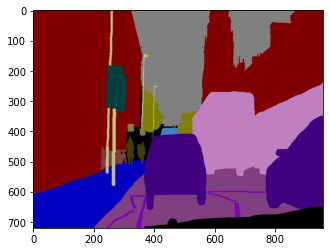

In [20]:
import numpy as np
reverse_mask = {}
for idx ,(key,val) in enumerate(mapping_dict.items()):
    reverse_mask[idx] = np.array(val)
    
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(mapping_dict.items())}

    
reverse_mask[0]

def map_class_to_rgb(p):
  
  return idx2rgb[p[0]]

mask = cv2.imread(os.path.join(PATH,"CamVid\\train_labels\\0001TP_006690_L.png"))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
masked = preprocess_mask(mapping_dict,mask)

rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(masked, axis=-1), -1))
plt.imshow(rgb_mask)


In [24]:
# using image date generator Training dataset
DATA_PATH = os.path.join(PATH,"CamVid")
BATCH_SIZE = 1
SEED = 1
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1./255)

mask_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen  = ImageDataGenerator()

image_gen = image_datagen.flow_from_directory(
    directory=DATA_PATH,
    target_size=(256,256),
    classes=['train'],
    batch_size= BATCH_SIZE,
    seed=SEED,
    class_mode= None
)

label_gen = mask_datagen.flow_from_directory(
    directory=DATA_PATH,
    target_size=(256,256),
    classes=['train_labels'],
    batch_size= BATCH_SIZE,
    seed=SEED,
    class_mode= None,
    color_mode='rgb'
)

train_gen = zip(image_gen,label_gen)


def preprocess_train_gen():
    for (img,mask) in train_gen:
        mask_img = preprocess_mask(mapping_dict,mask)
        yield(img,mask_img)
        


Found 421 images belonging to 1 classes.
Found 421 images belonging to 1 classes.


In [25]:
image_gen_val = image_datagen.flow_from_directory(
    directory=DATA_PATH,
    target_size=(256,256),
    classes=['val'],
    batch_size= BATCH_SIZE,
    seed=SEED,
    class_mode= None
)

label_gen_val = mask_datagen.flow_from_directory(
    directory=DATA_PATH,
    target_size=(256,256),
    classes=['val_labels'],
    batch_size= BATCH_SIZE,
    seed=SEED,
    class_mode= None,
    color_mode='rgb'
)

val_gen = zip(image_gen,label_gen)


def preprocess_val_gen():
    for (img,mask) in val_gen:
        mask_img = preprocess_mask(mapping_dict,mask)
        yield(img,mask_img)
        
x = next(preprocess_val_gen())
x[0][0].shape

Found 112 images belonging to 1 classes.
Found 112 images belonging to 1 classes.


(256, 256, 3)

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4) ,loss = 'categorical_crossentropy',metrics= ['accuracy'])

In [44]:
from hrnet import seg_hrnet

model = seg_hrnet(256,256,3,32)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4) ,loss = 'categorical_crossentropy',metrics= ['accuracy'])

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint
chk = ModelCheckpoint('hrnet.hdf5',monitor='val_loss',save_best_only=True,verbose=1)
history = model.fit_generator(preprocess_train_gen(),
                    validation_data=preprocess_val_gen(),
                    steps_per_epoch=421,
                    validation_steps=100,
                    epochs=20,
                    callbacks=[chk])

Epoch 1/20
421/421 [==============================] - 127s 302ms/step - loss: 0.4247 - accuracy: 0.8728 - val_loss: 1.1194 - val_accuracy: 0.7197

Epoch 00001: val_loss improved from inf to 1.11939, saving model to hrnet.hdf5
Epoch 2/20
421/421 [==============================] - 128s 303ms/step - loss: 0.4275 - accuracy: 0.8717 - val_loss: 0.9449 - val_accuracy: 0.7488

Epoch 00002: val_loss improved from 1.11939 to 0.94495, saving model to hrnet.hdf5
Epoch 3/20
421/421 [==============================] - 128s 303ms/step - loss: 0.4176 - accuracy: 0.8745 - val_loss: 1.1732 - val_accuracy: 0.7212

Epoch 00003: val_loss did not improve from 0.94495
Epoch 4/20
421/421 [==============================] - 127s 302ms/step - loss: 0.4109 - accuracy: 0.8768 - val_loss: 1.0971 - val_accuracy: 0.7317

Epoch 00004: val_loss did not improve from 0.94495
Epoch 5/20
421/421 [==============================] - 126s 301ms/step - loss: 0.4047 - accuracy: 0.8790 - val_loss: 1.1868 - val_accuracy: 0.7134

E

In [34]:
def predict_visualize(image_path,alpha = 0.7):
    '''
    Predicts image mask and make overlayed mask for visaualization
    inputs :
        image_path : path for image to be predicted
        alpha : alpha value for mask overlay
        
    returns :
        pred : predicted mask image of shape (256,256,32)
        
    '''
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(256,256),interpolation = cv2.INTER_AREA)
    
    pred = model.predict(np.expand_dims(image,0)/255)
    
    pred = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(pred, axis=-1), -1))
    pred_vis = np.reshape(pred,(256,256,3))

    vis = cv2.addWeighted(image,1.,pred_vis,alpha,0, dtype = cv2.CV_32F)/255
    
    fig,ax = plt.subplots(1,3)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    ax[0].imshow(image)
    ax[1].imshow(pred_vis)
    ax[2].imshow(vis)
    #ax[2].imshow(pred_vis,alpha = alpha)
    
    ax[0].title.set_text('Image')
    ax[1].title.set_text('Predicted mask')
    ax[2].title.set_text('masked image')
    
    
    return pred_vis,image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


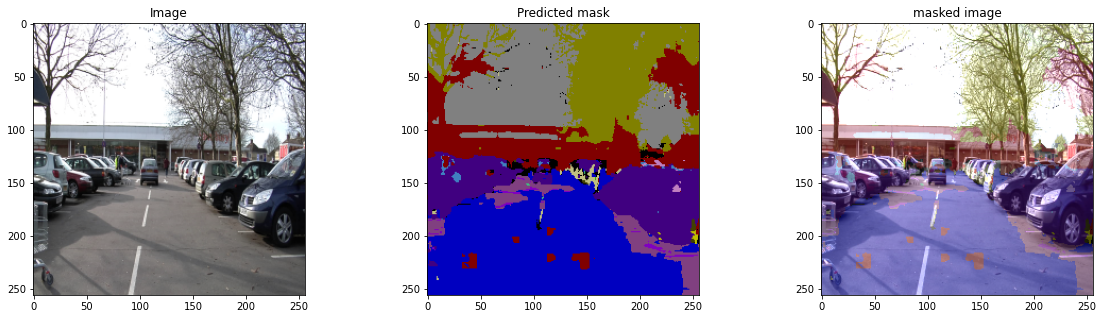

In [37]:
from tensorflow.keras.models import load_model
model.load_weights('hrnet.hdf5')
pred = predict_visualize(os.path.join(PATH,"CamVid\\test\\0006R0_f02520.png"),alpha = 0.4)
